In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
from cvxopt import matrix, solvers
from sklearn.model_selection import train_test_split
import scipy
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import random

In [4]:
dataX = pd.read_csv("data/Xtr0.csv", header=None)
dataY = pd.read_csv("data/Ytr0.csv", index_col=0)

In [5]:
dataX = dataX[0].apply(lambda x: pd.Series(list(x)))

In [6]:
dataY.head()

,Bound
0,1
1,0
2,1
3,1
4,0


## Kernels

In [7]:
def gaussian_kernel_matrix(X, sigma=1):
    return np.exp(- np.sum((X - X[:,None])**2, axis=-1) / (2*sigma**2))

In [8]:
def polynomial_kernel_matrix(X, deg=1):
    X_intercept = np.concatenate((X,np.ones(X.shape[0]).reshape(-1,1)), axis=1)
    return np.sum(X_intercept*X_intercept[:,None], axis=-1)**deg

### Kernel ridge regression (KRR)

In [9]:
def KRR(K, y, l=0.1):
    A = K + l * len(K)*np.eye(len(K))
    return scipy.linalg.solve(A, y, sym_pos=True)

## Simple Basic Tests

### Generating fake sine data for Regression

In [249]:
def fake_sinus(x, norm = 1):
    data = []
    for i in range(len(x)):
        a = random.random()/norm
        data.append(np.cos(x[i])+a)
    return data

In [250]:
def generate_noisy_sine_data(start=0., end=3, freq=0.01):
    return np.array([[i,fake_sinus([i], norm = 2)[0]] for i in np.arange(start, end, freq)])

In [251]:
def plot_data(data):    
    plt.plot(data[:,0], data[:,1])
    plt.show()

In [252]:
data = generate_noisy_sine_data()

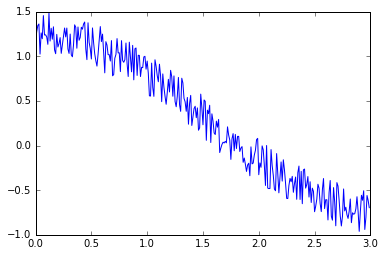

In [253]:
plot_data(data)

In [254]:
X = data[:,0]
X = X[:,None]
Y = data[:,1]

In [255]:
K = gaussian_kernel_matrix(X)

##### testing KRR

In [256]:
alpha = KRR(K, Y,l=0.001)
y_pred = np.dot(K,alpha)

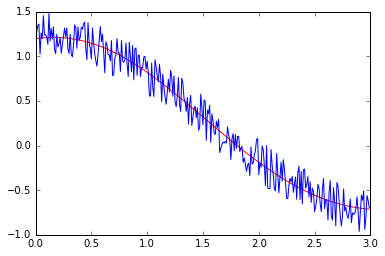

In [257]:
plt.plot(X,y_pred, color='red')
plt.plot(X, Y, color="blue")
plt.show()

### SVM (dual formulation)

In [17]:
class SVM(object):
    
    def __init__(self, lmbd=0.1, x0=None):
        self.lmbd = lmbd
        self.x0= x0
    
    def train(self, K, y):
        dim = K.shape[0]
        assert dim == len(y)
        diag_y = np.diag(y)
        idt = np.identity(dim)
        P = 1 / (2*self.lmbd) * np.dot(diag_y, np.dot(K, diag_y))
        q = - np.ones(dim)
        G = np.concatenate((idt, -idt))
        h = np.concatenate((np.ones(dim) / dim, np.zeros(dim)))
        if self.x0 is None:
            self.x0 = np.ones(dim)/(2*dim)
        res = solvers.qp(matrix(P), matrix(q), matrix(G), matrix(h), initvals=self.x0)['x']
        self.alpha = np.dot(diag_y, res)/(2*self.lmbd)
        
    def predict(self, K):
        return np.sign(np.dot(K,self.alpha).reshape(-1))

### Generating fake Binary Linearly separable data for Classification

In [259]:
def generate_points(n_samples=1000, offset=3.5):
    zero_labels = 0.5*np.random.randn(n_samples//2, 2)
    one_lables = 0.5*np.random.randn(n_samples//2, 2) + offset
    return zero_labels, one_lables

In [260]:
def generate_dataset(zero_labels, one_lables):
    data = np.concatenate((zeros, ones), axis=0)
    data = np.concatenate((data,
                np.concatenate((-np.ones([500, 1]), 
                                np.ones([500,1])))
                ),
                axis=1)
    np.random.shuffle(data)
    X = data[:,:2]
    y = data[:,-1]
    return X,y

In [261]:
def plot_datapoints(zero_labels, one_labels):
    plt.figure(1, figsize=(8,6))
    plt.scatter(zero_labels[:,0], zero_labels[:,1], color='blue', label='-1')
    plt.scatter(one_labels[:,0], one_labels[:,1], color='red', label='1')
    plt.legend()
    plt.show()

In [262]:
zeros, ones = generate_points(offset=0.8)

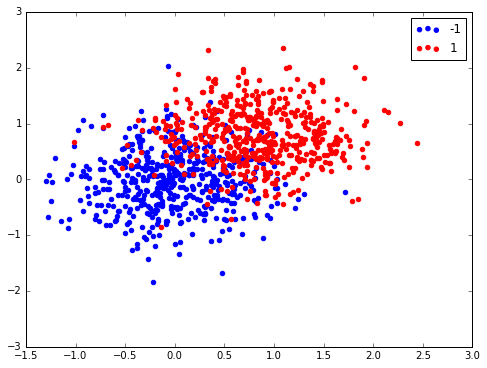

In [263]:
plot_datapoints(zeros, ones)

In [264]:
X, y = generate_dataset(zeros, ones)

##### testing SVM

In [265]:
K = polynomial_kernel_matrix(X, deg=1)

In [266]:
def get_weights_and_intercept(X, K, y, lmbd, x0):
    svm = SVM()
    svm.train(K,y)
    #svm = SVM(K,y,lmbd,x0=np.ones_like(y)/(2*len(y)))
    #alpha = svm.solve_qp()
    #alpha = np.dot(K,res).reshape(-1)
    X_intercept = np.concatenate((X,np.ones(X.shape[0]).reshape(-1,1)), axis=1)
    W = np.sum(X_intercept * svm.alpha.reshape(-1,1), axis=0)
    w = W[:-1]
    b = W[-1]
    return w, b

In [267]:
w,b = get_weights_and_intercept(X,K,y, 0.01, x0=np.ones_like(y)/(2*len(y)))

/Users/karlhajjar/anaconda/lib/python3.5/site-packages/cvxopt/coneprog.py:2111: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if 'x' in initvals:
/Users/karlhajjar/anaconda/lib/python3.5/site-packages/cvxopt/coneprog.py:2116: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if 's' in initvals:
/Users/karlhajjar/anaconda/lib/python3.5/site-packages/cvxopt/coneprog.py:2131: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if 'y' in initvals:
/Users/karlhajjar/anaconda/lib/python3.5/site-packages/cvxopt/coneprog.py:2136: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if 'z' in initvals:


     pcost       dcost       gap    pres   dres
 0:  0.0000e+00 -1.0000e+00  2e+03  4e+01  1e+00
 1: -5.5440e-01 -1.5713e+00  3e+01  5e-01  1e-02
 2: -4.3069e-01 -1.4643e+00  1e+00  1e-03  2e-05
 3: -5.1450e-01 -6.5822e-01  1e-01  1e-04  3e-06
 4: -5.8492e-01 -6.0702e-01  2e-02  2e-05  3e-07
 5: -5.9353e-01 -6.0111e-01  8e-03  5e-06  1e-07
 6: -5.9559e-01 -5.9965e-01  4e-03  2e-06  5e-08
 7: -5.9675e-01 -5.9879e-01  2e-03  1e-06  2e-08
 8: -5.9759e-01 -5.9816e-01  6e-04  2e-07  5e-09
 9: -5.9785e-01 -5.9795e-01  9e-05  4e-08  8e-10
10: -5.9790e-01 -5.9790e-01  3e-06  1e-09  2e-11
11: -5.9790e-01 -5.9790e-01  6e-08  2e-11  4e-13
Optimal solution found.


In [268]:
model = SVM(lmbd=0.01)

In [269]:
model.train(K,y)

/Users/karlhajjar/anaconda/lib/python3.5/site-packages/cvxopt/coneprog.py:2111: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if 'x' in initvals:
/Users/karlhajjar/anaconda/lib/python3.5/site-packages/cvxopt/coneprog.py:2116: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if 's' in initvals:
/Users/karlhajjar/anaconda/lib/python3.5/site-packages/cvxopt/coneprog.py:2131: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if 'y' in initvals:
/Users/karlhajjar/anaconda/lib/python3.5/site-packages/cvxopt/coneprog.py:2136: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if 'z' in initvals:


     pcost       dcost       gap    pres   dres
 0:  0.0000e+00 -1.0000e+00  2e+03  4e+01  1e+00
 1: -4.4504e-01 -1.4618e+00  3e+01  5e-01  1e-02
 2: -3.2049e-01 -1.3304e+00  2e+00  3e-02  6e-04
 3: -3.1341e-01 -6.3968e-01  4e-01  1e-03  3e-05
 4: -3.6317e-01 -4.1800e-01  6e-02  2e-04  5e-06
 5: -3.8298e-01 -3.9162e-01  9e-03  3e-05  6e-07
 6: -3.8605e-01 -3.8785e-01  2e-03  5e-06  1e-07
 7: -3.8662e-01 -3.8716e-01  6e-04  1e-06  3e-08
 8: -3.8680e-01 -3.8695e-01  2e-04  3e-07  7e-09
 9: -3.8686e-01 -3.8688e-01  3e-05  4e-08  9e-10
10: -3.8687e-01 -3.8687e-01  5e-06  1e-10  2e-12
11: -3.8687e-01 -3.8687e-01  2e-07  5e-12  1e-13
Optimal solution found.


In [270]:
y_pred = model.predict(K)

In [271]:
error = np.mean(np.abs(y_pred - y) * 0.5)

In [272]:
error

0.13

In [273]:
def plot_predictions(X, y_true, y_pred, w=None, b=None):
    
    xmin = np.min(X[:,0])
    xmax = np.max(X[:,0])
    
    ymin = np.min(X[:,1])
    ymax = np.max(X[:,0])
    
    plt.figure(1, figsize=(8,6))
    
    if w is not None and b is not None:
        x1 = np.array([0,-b/w[1]])
        x2 = np.array([-b/w[0],0])
        a = (x2[1] - x1[1]) / (x2[0] - x1[0])
        c = x1[1] - a * x1[0] 
        ts = np.arange(xmin,xmax+0.5, 0.01)
        ys = [a*t + c for t in ts]
        plt.plot(ts, ys, color='g')
        plt.ylim(ymin,ymax+0.5)
        
    on_target = y_pred == y_true
    one_indices = y_true == 1.
    TP = X[on_target * one_indices]
    FN = X[~on_target * one_indices]
    TN = X[on_target * ~one_indices]
    FP = X[~on_target * ~one_indices]
    plt.scatter(TP[:,0], TP[:,1], color='red', label='TP')
    plt.scatter(TN[:,0], TN[:,1], color='blue', label='TN')
    plt.scatter(FN[:,0], FN[:,1], color='violet', label='FN')
    plt.scatter(FP[:,0], FP[:,1], color='purple', label='FP')
    plt.legend()
    plt.show()

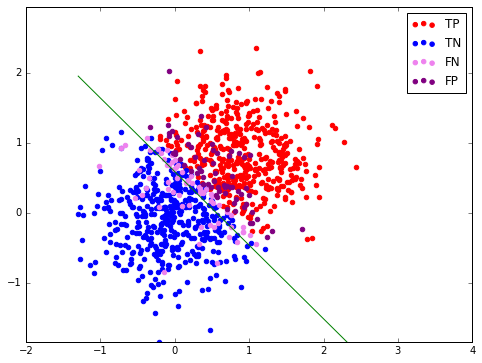

In [274]:
plot_predictions(X,y,y_pred, w, b)

## Testing SVM on the real data using length 50 features

In [125]:
y = dataY.values
X = pd.read_csv("data/Xtr0_mat50.csv", sep=' ',header=None).values

In [126]:
X_train, X_test, Y_train, Y_test = train_test_split(X,y.reshape(-1),test_size=0.2)

In [127]:
X_train.shape

(1600, 50)

In [128]:
Y_train.shape

(1600,)

In [129]:
K_train = polynomial_kernel_matrix(X_train, deg=1)

In [130]:
K_train.shape

(1600, 1600)

In [131]:
model = SVM(lmbd = 0.1)

In [132]:
Y_train.shape

(1600,)

In [133]:
model.train(K, Y_train)

//anaconda/lib/python3.5/site-packages/cvxopt/coneprog.py:2111: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if 'x' in initvals:
//anaconda/lib/python3.5/site-packages/cvxopt/coneprog.py:2116: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if 's' in initvals:
//anaconda/lib/python3.5/site-packages/cvxopt/coneprog.py:2131: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if 'y' in initvals:
//anaconda/lib/python3.5/site-packages/cvxopt/coneprog.py:2136: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if 'z' in initvals:


     pcost       dcost       gap    pres   dres
 0:  0.0000e+00 -1.0000e+00  3e+03  6e+01  1e+00
 1: -6.2967e-01 -1.5308e+00  4e+01  6e-01  1e-02
 2: -4.9171e-01 -1.4669e+00  1e+00  5e-17  6e-16
 3: -5.9719e-01 -6.7746e-01  8e-02  5e-18  6e-16
 4: -6.3296e-01 -6.3679e-01  4e-03  4e-18  6e-16
 5: -6.3468e-01 -6.3476e-01  8e-05  3e-18  6e-16
 6: -6.3471e-01 -6.3471e-01  1e-06  2e-18  6e-16
 7: -6.3471e-01 -6.3471e-01  1e-08  5e-18  5e-16
Optimal solution found.


In [134]:
y_train_pred = model.predict(K)

In [137]:
y_train_pred.sum()

1600.0

In [136]:
error = np.mean(np.abs(y_train_pred - Y_train) * 0.5)
print(error)

0.25125


In [104]:
X_recomp = np.concatenate((X_train, X_test), axis=0)

In [105]:
X_recomp.shape

(2000, 50)

In [106]:
K_tot = polynomial_kernel_matrix(X_recomp,deg=2)

In [107]:
K_tot.shape

(2000, 2000)

In [108]:
K_test = K_tot[len(X_train):,:len(X_train)]

In [109]:
K_test.shape

(400, 1600)

In [110]:
y_test_pred = model.predict(K_test)

In [111]:
test_error = np.mean(np.abs(y_test_pred - Y_test) * 0.5)
print(test_error)

0.26625


### BIG tests

In [233]:
for sigma in [1e-3,1e-2,1e-1,2e-1,5e-1,1]:
    K = gaussian_kernel_matrix(X, sigma=sigma)
    for l in [1e-3,1e-2,1e-1,5e-1,1,10]:
        alpha = KRR(K, y, l=l)
        y_pred = np.dot(K,alpha)
        for limit in [0.2,0.4,0.5,0.7]:  
            y_pred_final = 1*(y_pred > limit)
            print('----')
            print('sigma = {}, lambda = {}, limit={}'.format(sigma,l, limit))
            print('training error : ')
            print(np.mean(np.abs(y_pred_final-y)))

----
sigma = 0.001, lambda = 0.001, limit=0.2
training error : 
0.0
----
sigma = 0.001, lambda = 0.001, limit=0.4
training error : 
0.5
----
sigma = 0.001, lambda = 0.001, limit=0.5
training error : 
0.5
----
sigma = 0.001, lambda = 0.001, limit=0.7
training error : 
0.5
----
sigma = 0.001, lambda = 0.01, limit=0.2
training error : 
0.5
----
sigma = 0.001, lambda = 0.01, limit=0.4
training error : 
0.5
----
sigma = 0.001, lambda = 0.01, limit=0.5
training error : 
0.5
----
sigma = 0.001, lambda = 0.01, limit=0.7
training error : 
0.5
----
sigma = 0.001, lambda = 0.1, limit=0.2
training error : 
0.5
----
sigma = 0.001, lambda = 0.1, limit=0.4
training error : 
0.5
----
sigma = 0.001, lambda = 0.1, limit=0.5
training error : 
0.5
----
sigma = 0.001, lambda = 0.1, limit=0.7
training error : 
0.5
----
sigma = 0.001, lambda = 0.5, limit=0.2
training error : 
0.5
----
sigma = 0.001, lambda = 0.5, limit=0.4
training error : 
0.5
----
sigma = 0.001, lambda = 0.5, limit=0.5
training error : 
0.

In [236]:
y_pred_final

array([[0],
       [0],
       [0],
       ..., 
       [0],
       [0],
       [0]])

In [321]:
big_X = np.concatenate((X_train, X_test),axis=0) 
for sigma in [0.2]:
    big_K = gaussian_kernel_matrix(big_X, sigma=sigma)
    K = big_K[:1600,:1600]
    K_test = big_K[1600:,:1600]
    for l in [0.002, 0.003,0.005,0.008,0.01]:
        alpha = KRR(K, Y_train, l=l)
        y_pred_test = np.dot(K_test,alpha)
        y_pred_train = np.dot(K,alpha)
        for limit in [0.5]:

            y_pred_final = 1*(y_pred_test > limit)
            print('----')
            print('sigma = {}, lambda = {}, limit={}'.format(sigma,l,limit))
            print('testing error : ')
            print(np.mean(np.abs(y_pred_final-Y_test)))
            y_pred_final = 1*(y_pred_train > limit)
            print('training error : ')
            print(np.mean(np.abs(y_pred_final-Y_train)))

----
sigma = 0.2, lambda = 0.002, limit=0.5
testing error : 
0.4175
training error : 
0.33625
----
sigma = 0.2, lambda = 0.003, limit=0.5
testing error : 
0.415
training error : 
0.3475
----
sigma = 0.2, lambda = 0.005, limit=0.5
testing error : 
0.41
training error : 
0.3525
----
sigma = 0.2, lambda = 0.008, limit=0.5
testing error : 
0.4175
training error : 
0.351875
----
sigma = 0.2, lambda = 0.01, limit=0.5
testing error : 
0.42
training error : 
0.3575


In [309]:
y_pred

array([[ 0.        ],
       [ 0.38461538],
       [ 0.38461538],
       ..., 
       [ 0.38461538],
       [ 0.        ],
       [ 0.38461538]])

In [288]:
alpha

array([[ -3.52111613e-09],
       [ -2.87455129e-09],
       [ -3.19436646e-09],
       ..., 
       [  6.24997281e-04],
       [ -4.01467883e-09],
       [  6.24996761e-04]])